<a href="https://colab.research.google.com/github/JuliaKoryukova/Machine-Learning/blob/main/08_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='#0066CC' size='6'>**Классическое машинное обучение**</font>  

<font size='5'>**Данные :**</font>  
скачать данные `kaggle competitions download -c bike-sharing-demand`

<font size='5'>**Описание данных :**</font>  
https://www.kaggle.com/competitions/bike-sharing-demand/data

Работа основана на конкурсе https://www.kaggle.com/competitions/bike-sharing-demand/overview

В конкурсе даны данные о почасовой аренде велосипедов за два года. Обучающий набор состоит из первых 19 дней каждого месяца, а тестовый набор — с 20-го числа до конца месяца. Необходимо спрогнозировать общее количество велосипедов, взятых напрокат в течение каждого часа, охватываемого тестовым набором, используя только информацию, доступную до начала периода аренды.

Оценка с использованием корня из среднеквадратичной логарифмической ошибки (RMSLE).   
RMSLE вычисляется по формуле
$$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(p_i + 1) - \log(a_i + 1) \right)^2}$$

Где:

- $ n $ — количество часов
- $ p_i $ — предсказанное количество
- $ a_i $ — фактическое количество
- $ \log(x) $ — натуральный логарифм


<img src="https://drive.google.com/uc?export=view&id=1lv9FV80T0d5iEtbuGnrS8K2BUUOqq4E-" alt="Описание изображения" width="600"/>


# <font color='#0066CC' size='6'> **Импорт и установка библиотек**

In [ ]:
!pip install shap
!pip install kaggle -q
!pip install gdown -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import json
import zipfile

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import shap

from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_log_error, make_scorer, mean_absolute_error, r2_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

# <font color='#0066CC' size='6'> **Загрузка данных**

In [ ]:
def load_dataset(from_kaggle=True) -> pd.DataFrame:
  if from_kaggle:
    # запросит разрешение к гугл диску, необходимо дать это разрешение
    drive.mount('/content/drive')
    # установим kaggle
    !pip install kaggle -q
    !mkdir ~/.kaggle
    # копируем kaggle.json (предварительно, необходимо сгенерить токен на
    # сайте kaggle и сохранить к себе на гугл диск) в папку ~/.kaggle/
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c bike-sharing-demand
  else:
    !gdown 1-ENvRYbjScwCDcscDllGfiT6CMvTA-E1
  # распаковка архива
  zip_ref = zipfile.ZipFile('bike-sharing-demand.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_sample_submission = pd.read_csv('sampleSubmission.csv')
  return df_train, df_test, df_sample_submission

In [ ]:
df_train, df_test, df_sample_submission = load_dataset(from_kaggle=True)

Mounted at /content/drive
  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 24.6MB/s]


In [ ]:
# это данные для примера, в таком виде необходимо сделать выборку и загрузить на kaggle
#  (для тех, кто хочет увидеть себя в лидерборде и оценить на сколько ваше решение лучше/хуже остальных)
df_sample_submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [ ]:
# это тестовые данные, для которых необходимо предсказать target, то есть применить модель,
#  которую вы разработаете на данных df_train
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
# на этих данных дальше необходимо разработать модель
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## <font color='#0066CC' size='5'> Определите роли переменных (целевая переменная, независимые переменные)

In [ ]:
x = df_train.drop('count', axis=1)
y = df_train['count']

In [ ]:
x.shape, y.shape

((10886, 11), (10886,))

(array([4284., 2337., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <BarContainer object of 10 artists>)

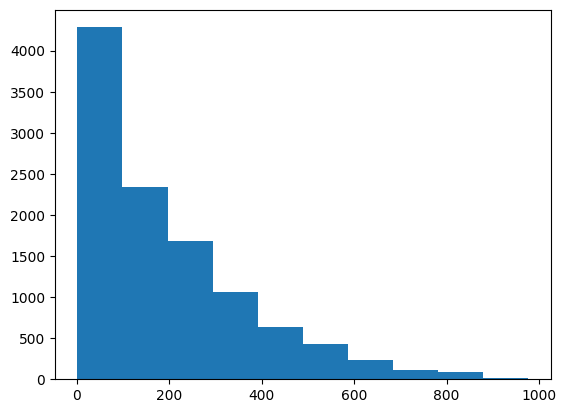

In [ ]:
# Распределение целевой переменной
plt.hist(y)

# <font color='#0066CC' size='6'> **Разведочный анализ данных**

## <font color='#0066CC' size='5'> Оценка размера датасета


1.   Сколько ГБ датасет
2.   Сколько строк и столбцов



In [ ]:
# Сколько kБ датасет
size_byte_train = df_train.memory_usage(index=True).sum()
size_kb_train = size_byte_train / 1024

size_byte_test = df_test.memory_usage(index=True).sum()
size_kb_test = size_byte_test / 1024

summa_size_df = size_kb_train + size_kb_test

print(f"The dataset df_train is {size_kb_train:.2f} kB")
print(f"The dataset df_test is {size_kb_test:.2f} kB")
print(f"The datasets df_train + df_test are {summa_size_df:.2f} kB")

The dataset df_train is 1020.69 kB
The dataset df_test is 456.66 kB
The datasets df_train + df_test are 1477.35 kB


## <font color='#0066CC' size='5'> Анализ категориальных признаков


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


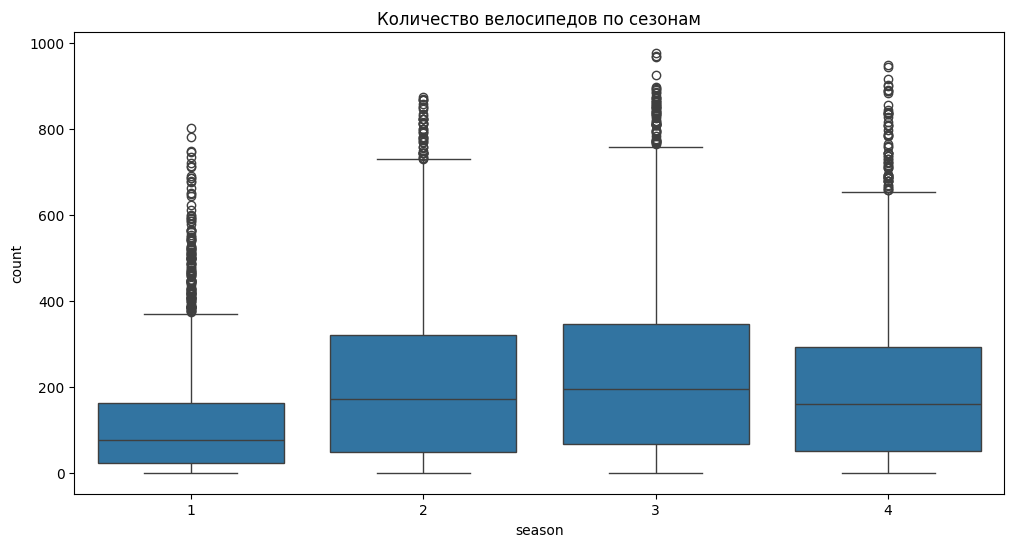

In [ ]:
# Визуализация распределения количества велосипедов в зависимости от сезона
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='count', data=df_train)
plt.title('Количество велосипедов по сезонам')
plt.show()

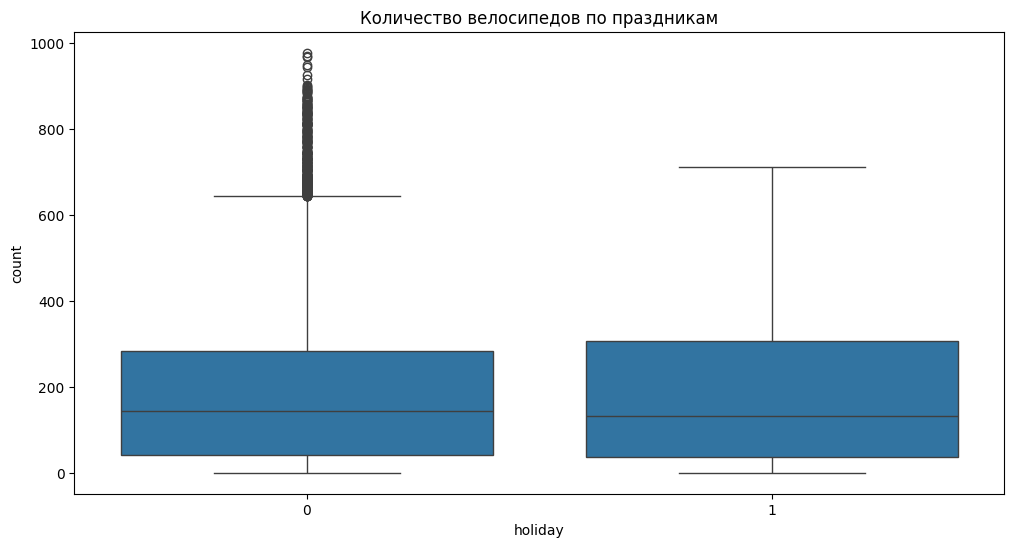

In [ ]:
# Визуализация распределения количества велосипедов в зависимости от праздников
plt.figure(figsize=(12, 6))
sns.boxplot(x='holiday', y='count', data=df_train)
plt.title('Количество велосипедов по праздникам')
plt.show()

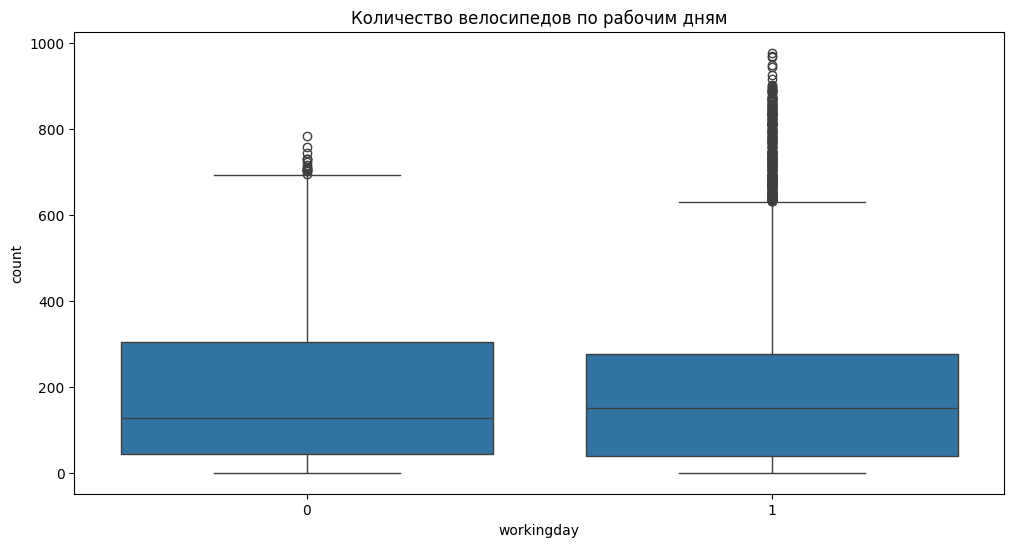

In [ ]:
# Визуализация распределения количества велосипедов в зависимости от рабочего дня
plt.figure(figsize=(12, 6))
sns.boxplot(x='workingday', y='count', data=df_train)
plt.title('Количество велосипедов по рабочим дням')
plt.show()

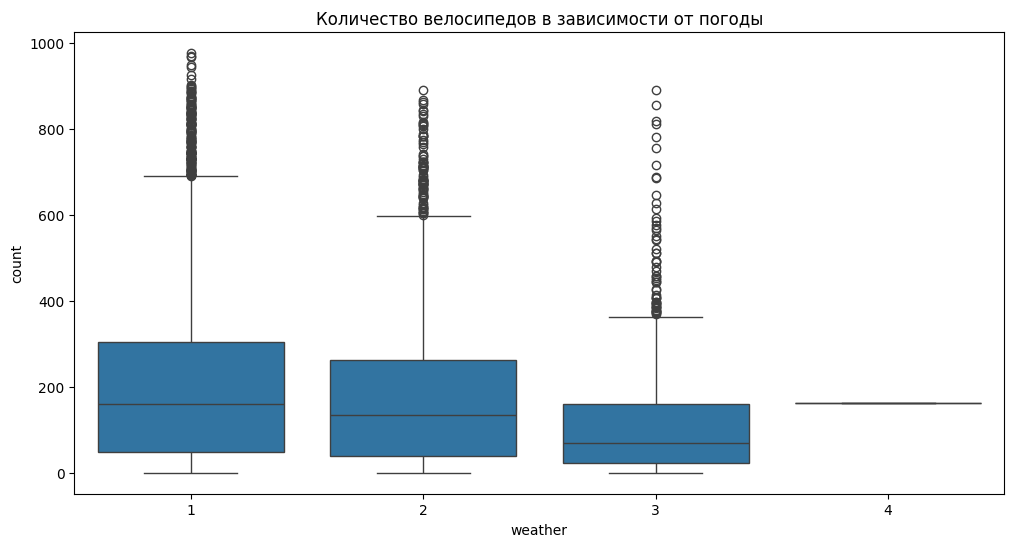

In [ ]:
# Визуализация распределения количества велосипедов в зависимости от погоды
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='count', data=df_train)
plt.title('Количество велосипедов в зависимости от погоды')
plt.show()

In [ ]:
# Среднее количество велосипедов для каждого сезона
seasons_stats = df_train.groupby('season')['count'].agg(['mean', 'std', 'min', 'max', 'median'])
print('Статистика по сезонам:\n', seasons_stats)

Статистика по сезонам:
               mean         std  min  max  median
season                                          
1       116.343261  125.273974    1  801    78.0
2       215.251372  192.007843    1  873   172.0
3       234.417124  197.151001    1  977   195.0
4       198.988296  177.622409    1  948   161.0


In [ ]:
# Среднее количество велосипедов для праздничных и непраздничных дней
holiday_stats = df_train.groupby('holiday')['count'].agg(['mean', 'std', 'min', 'max', 'median'])
print('Статистика по праздничным и непраздничным дням:\n', holiday_stats)

Статистика по праздничным и непраздничным дням:
                mean         std  min  max  median
holiday                                          
0        191.741655  181.513131    1  977   145.0
1        185.877814  168.300531    1  712   133.0


In [ ]:
# Среднее количество велосипедов для рабочих и нерабочих дней
workingday_stats = df_train.groupby('holiday')['count'].agg(['mean', 'std', 'min', 'max', 'median'])
print('Статистика по рабочим и нерабочим дням:\n', workingday_stats)

Статистика по рабочим и нерабочим дням:
                mean         std  min  max  median
holiday                                          
0        191.741655  181.513131    1  977   145.0
1        185.877814  168.300531    1  712   133.0


In [ ]:
# Среднее количество велосипедов для разных погодных условий
weather_stats = df_train.groupby('weather')['count'].agg(['mean', 'std', 'min', 'max', 'median'])
print("Статистика для разных погодных условий:\n", weather_stats)

Статистика для разных погодных условий:
                mean         std  min  max  median
weather                                          
1        205.236791  187.959566    1  977   161.0
2        178.955540  168.366413    1  890   134.0
3        118.846333  138.581297    1  891    71.0
4        164.000000         NaN  164  164   164.0


## <font color='#0066CC' size='5'> Анализ пропусков


In [ ]:
missing_data = df_train.isnull().sum()
missing_data

,0
datetime,0
season,0
holiday,0
workingday,0
weather,0
temp,0
atemp,0
humidity,0
windspeed,0
casual,0


## <font color='#0066CC' size='5'> Анализ выбросов


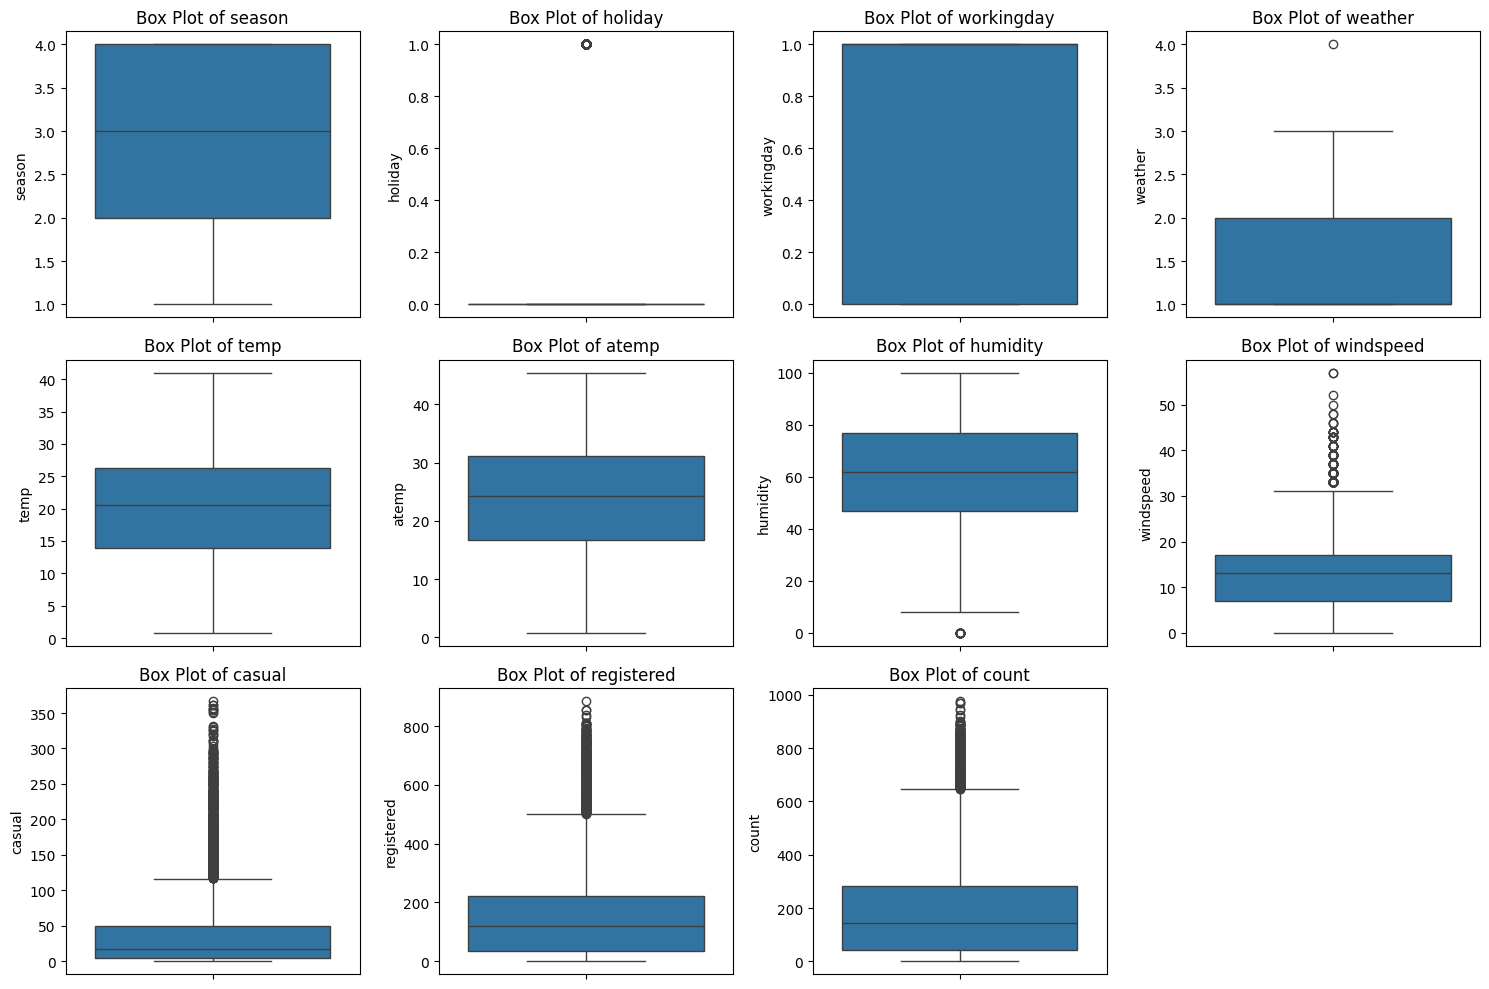

In [ ]:
numeric_columns = df_train.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
  plt.subplot(3, 4, i)
  sns.boxplot(y=df_train[column])
  plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

In [ ]:
# Поиск выбросов
results = {'Столбец': [], 'Выбросы': []}
# Расчет IQR
for column in numeric_columns:
  Q1 = df_train[column].quantile(0.25)
  Q3 = df_train[column].quantile(0.75)
  IQR = Q3 - Q1

  # Определение выбросов
  outliers_iqr_train = df_train[column][(df_train[column] < Q1 - 1.5 * IQR) | (df_train[column] > Q3 + 1.5 * IQR)]

  # Результаты
  results['Столбец'].append(column)
  results['Выбросы'].append(outliers_iqr_train.shape[0])

  # Создаем таблицу
  df_results = pd.DataFrame(results)

df_results

,Столбец,Выбросы
0,season,0
1,holiday,311
2,workingday,0
3,weather,1
4,temp,0
5,atemp,0
6,humidity,22
7,windspeed,227
8,casual,749
9,registered,423


In [ ]:
# Статические характеристики по столбцам с выбросами
stats = df_train[['holiday', 'humidity', 'windspeed', 'casual', 'registered']].describe()
stats

,holiday,humidity,windspeed,casual,registered
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,61.886460,12.799395,36.021955,155.552177
std,0.166599,19.245033,8.164537,49.960477,151.039033
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,47.000000,7.001500,4.000000,36.000000
50%,0.000000,62.000000,12.998000,17.000000,118.000000
75%,0.000000,77.000000,16.997900,49.000000,222.000000
max,1.000000,100.000000,56.996900,367.000000,886.000000


# <font color='#0066CC' size='6'> **Разделение данных на тренировочную и тестовые выборки**

In [ ]:
# Для начала приведу столбцы в удобный вариант
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

# Преобразую столбец datetime в тип datetime
df_train_copy['datetime'] = pd.to_datetime(df_train_copy['datetime'])
df_test_copy['datetime'] = pd.to_datetime(df_test_copy['datetime'])

# Извлекаю признаки из datetime
df_train_copy['hour'] = df_train_copy['datetime'].dt.hour
df_train_copy['day'] = df_train_copy['datetime'].dt.day
df_train_copy['month'] = df_train_copy['datetime'].dt.month
df_train_copy['year'] = df_train_copy['datetime'].dt.year
df_train_copy['dayofweek'] = df_train_copy['datetime'].dt.dayofweek

df_test_copy['hour'] = df_test_copy['datetime'].dt.hour
df_test_copy['day'] = df_test_copy['datetime'].dt.day
df_test_copy['month'] = df_test_copy['datetime'].dt.month
df_test_copy['year'] = df_test_copy['datetime'].dt.year
df_test_copy['dayofweek'] = df_test_copy['datetime'].dt.dayofweek

# Нужно спрогнозировать общее количество велосипедов, а признаки casual и registered
# по сути целевые метки, разложенные по разным столбцам
# поэтому эти столбцы я удалю
df_train_copy = df_train_copy.drop(['datetime', 'casual', 'registered'], axis=1)
df_test_copy = df_test_copy.drop(['datetime'], axis=1)

In [ ]:
df_test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [ ]:
df_test_copy.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,0,20,1,2011,3
1,1,0,1,1,10.66,13.635,56,0.0000,1,20,1,2011,3
2,1,0,1,1,10.66,13.635,56,0.0000,2,20,1,2011,3


In [ ]:
x = df_train_copy.drop('count', axis=1)
y = df_train_copy['count']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek
2815,3,0,1,1,27.88,31.820,83,6.0032,5,6,7,2011,2
8695,3,0,0,1,36.90,40.910,39,19.9995,16,4,8,2012,5
8406,3,0,1,1,32.80,35.605,41,16.9979,15,11,7,2012,2
1543,2,0,0,2,14.76,18.180,93,7.0015,4,10,4,2011,6
4952,4,0,0,1,13.12,15.150,45,16.9979,10,19,11,2011,5


# <font color='#0066CC' size='6'> **Подготовка данных к обучению**



1.   Обработка категориальных переменных
2.   Обработка пропусков
3.   Нормализация данных
4.   Обработка выбросов (если в данных есть выбросы)



1. Обработка категориальных переменных

In [ ]:
# Расчет корреляции
corr_matrix_train = x_train.corr()
corr_target_train = x_train.corrwith(y_train).sort_values(ascending=False)
print('Корреляция с count:\n', corr_target_train)

Корреляция с count:
 hour          0.401573
temp          0.390023
atemp         0.385990
year          0.259431
month         0.164306
season        0.161001
windspeed     0.098819
day           0.017012
workingday    0.013617
dayofweek    -0.004942
holiday      -0.008153
weather      -0.131122
humidity     -0.318070
dtype: float64


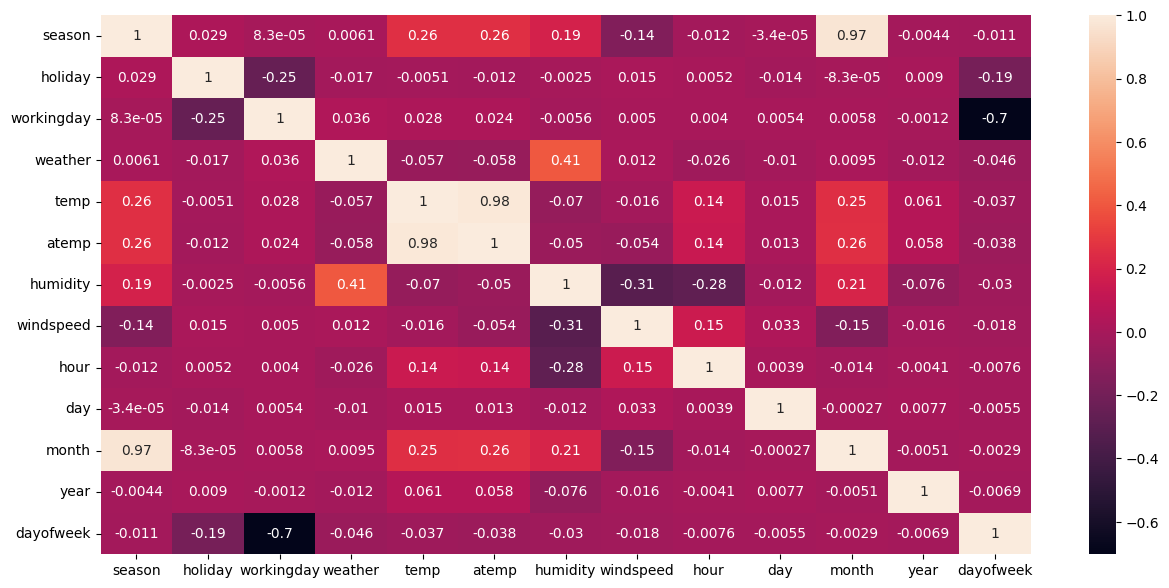

In [ ]:
# Отрисовка матрицы корреляций train
plt.figure(figsize=(15, 7))
sns.heatmap(data=corr_matrix_train, annot=True)
plt.show()

2. Обработка выбросов

In [ ]:
# убираем выбросы с помощью интерквантильного размаха
numeric_columns = x_train.select_dtypes(include=['float64', 'int64']).columns

# Функция для замены выбросов на медиану
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[column].median()
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = median

# Замена выбросов на медиану для всех числовых признаков
for column in numeric_columns:
    replace_outliers_with_median(x_train, column)
    replace_outliers_with_median(x_test, column)

In [ ]:
# Повторный поиск аномалий в выбросах
results = {'Столбец': [], 'Train Outliers': [], 'Test Outliers': []}
# Расчет IQR
for column in numeric_columns:
  Q1 = x_train[column].quantile(0.25)
  Q3 = x_train[column].quantile(0.75)
  IQR = Q3 - Q1

  # Определение выбросов
  outliers_iqr_train = x_train[column][(x_train[column] < Q1 - 1.5 * IQR) | (x_train[column] > Q3 + 1.5 * IQR)]
  outliers_iqr_test = x_test[column][(x_test[column] < Q1 - 1.5 * IQR) | (x_test[column] > Q3 + 1.5 * IQR)]

  # Результаты
  results['Столбец'].append(column)
  results['Train Outliers'].append(outliers_iqr_train.shape[0])
  results['Test Outliers'].append(outliers_iqr_test.shape[0])

  # Создаем таблицу
  df_results = pd.DataFrame(results)

df_results

,Столбец,Train Outliers,Test Outliers
0,season,0,0
1,holiday,0,0
2,workingday,0,0
3,weather,0,0
4,temp,0,0
5,atemp,0,0
6,humidity,0,0
7,windspeed,0,0


Интерквантильный размах помог избавиться от выбросов

3. Обработка пропусков и нулевых значений

In [ ]:
print('Нулевые значения в каждой колонке train:\n', x_train.isnull().sum())
print('----------------')
print('Нулевые значения в каждой колонке test:\n', x_test.isnull().sum())

Нулевые значения в каждой колонке train:
 season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
hour          0
day           0
month         0
year          0
dayofweek     0
dtype: int64
----------------
Нулевые значения в каждой колонке test:
 season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
hour          0
day           0
month         0
year          0
dayofweek     0
dtype: int64


In [ ]:
# Обработка пропусков
missing_data_train = x_train.isnull().sum()
missing_data_train = missing_data_train[missing_data_train > 0]

missing_data_test= x_test.isnull().sum()
missing_data_test = missing_data_test[missing_data_test > 0]

print("Пропущенные значения в каждой колонке train:\n", missing_data_train)
print('----------------')
print("Пропущенные значения в каждой колонке test:\n", missing_data_test)

Пропущенные значения в каждой колонке train:
 Series([], dtype: int64)
----------------
Пропущенные значения в каждой колонке test:
 Series([], dtype: int64)


4. Нормализация данных

In [ ]:
x_test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek
3133,3,0,1,1,33.62,40.150,59,0.0000,11,19,7,2011,1
5786,1,0,0,1,4.10,6.820,54,6.0032,6,16,1,2012,0
5224,4,0,0,1,9.84,11.365,48,12.9980,18,11,12,2011,6


In [ ]:
x_train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek
2815,3,0,1,1,27.88,31.820,83,6.0032,5,6,7,2011,2
8695,3,0,0,1,36.90,40.910,39,19.9995,16,4,8,2012,5
8406,3,0,1,1,32.80,35.605,41,16.9979,15,11,7,2012,2


In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [ ]:
x_train_scaled.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek
0,0.441439,0.0,0.684445,-0.657353,0.977262,0.960505,1.103712,-0.852447,-0.945962,-0.724466,0.138224,-1.003221,-0.509628
1,0.441439,0.0,-1.461037,-0.657353,2.135457,2.034991,-1.202194,1.044729,0.643217,-1.090408,0.429385,0.996790,0.990656
2,0.441439,0.0,0.684445,-0.657353,1.609005,1.407912,-1.097380,0.637867,0.498746,0.190388,0.138224,0.996790,-0.509628


In [ ]:
x_test_scaled.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek
0,0.441439,0.0,0.684445,-0.657353,1.714295,1.945155,-0.154055,-1.666171,-0.079137,1.654154,0.138224,-1.003221,-1.009722
1,-1.351912,0.0,-1.461037,-0.657353,-2.076161,-1.994626,-0.416090,-0.852447,-0.801491,1.105242,-1.608740,0.996790,-1.509817
2,1.338114,0.0,-1.461037,-0.657353,-1.339128,-1.457383,-0.730532,0.095687,0.932159,0.190388,1.594028,-1.003221,1.490750


# <font color='#0066CC' size='6'> **Построение моделей**

## <font color='#0066CC'> Методы обучения без учителя (Unsupervised learning)

<font color='#0066CC'> Построение модели кластеризации, исключив предварительно из данных целевой признак. Далее оценка качества кластеризации с помощью метрик без целевого признака и с помощью метрик на основании целевого признака

Метрики без целевого признака

In [ ]:
# Определение числа кластеров с помощью метода локтя
max_k = 11
wcss = []

for i in range(1, max_k):
  kmeans_wcss = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
  kmeans_wcss.fit(x_train_scaled)
  wcss.append(kmeans_wcss.inertia_)

print('WCSS для каждой модели:')

for i, wcss_value in enumerate(wcss):
  print(f'Кластеров: {i+1}, WCSS: {wcss_value}')

WCSS для каждой модели:
Кластеров: 1, WCSS: 104495.99999999975
Кластеров: 2, WCSS: 87130.51661628259
Кластеров: 3, WCSS: 77380.96769535489
Кластеров: 4, WCSS: 70738.21219907221
Кластеров: 5, WCSS: 66430.72035652064
Кластеров: 6, WCSS: 62936.163245365584
Кластеров: 7, WCSS: 60139.94675215874
Кластеров: 8, WCSS: 57477.57398702952
Кластеров: 9, WCSS: 55629.415518299014
Кластеров: 10, WCSS: 53765.87827525242


In [ ]:
# Визуализация определения числа кластеров с помощью метода локтя
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(1, max_k)), y=wcss, mode='lines', name='WCSS'))

fig.update_layout(
    title = 'Выбор количества кластеров методом локтя',
    xaxis_title = 'Количество кластеров',
    yaxis_title = 'WCSS'
)
fig.show()

In [ ]:
optimal_wcss_clusters = 4

In [ ]:
# Определение числа кластеров с помощью метода силуэта
# Значение от -1 до 1. Ближе к 1 - хорошая кластеризация
silhouette_scores = []
for i in range(2, max_k):
  kmeans_silhouette = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
  kmeans_silhouette.fit(x_train_scaled)
  score = silhouette_score(x_train_scaled, kmeans_silhouette.labels_)
  silhouette_scores.append(score)

silhouette_avg = max(silhouette_scores)
optimal_avg_clusters = silhouette_scores.index(silhouette_avg) + 2
print(f'Silhouette Score: {silhouette_avg}\nОптимальное количество кластеров: {optimal_avg_clusters}')

Silhouette Score: 0.17014118729129996
Оптимальное количество кластеров: 2


In [ ]:
# Визуализация определения числа кластеров с помощью метода силуэта
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, max_k)), y=silhouette_scores, mode='lines', name='Silhouette Scores'))

fig.update_layout(
    title = 'Выбор количества кластеров методом силуэта',
    xaxis_title = 'Количество кластеров',
    yaxis_title = 'Silhouette Scores'
)
fig.show()

In [ ]:
# Определение числа кластеров с помощью метода Дэвиса-Болдина
# Измеряет среднее отношение расстояние между кластерами к среднему внутрикластерному расстоянию
# Более низкое значение - лучшее качество кластеризации
davies_bouldin_scores = []
for i in range(2, max_k):
  kmeans_davies = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init = 10)
  kmeans_davies.fit(x_train_scaled)
  score = davies_bouldin_score(x_train_scaled, kmeans_davies.labels_)
  davies_bouldin_scores.append(score)

db_score = min(davies_bouldin_scores)
optimal_db_clusters = davies_bouldin_scores.index(db_score) + 2
print(f'Davies-Bouldin Index: {db_score},\nОптимальное количество кластеров: {optimal_db_clusters}')

Davies-Bouldin Index: 1.871217164752065,
Оптимальное количество кластеров: 9


In [ ]:
# Визуализация определения числа кластеров с помощью метода Дэвиса-Болдина
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, max_k)), y=davies_bouldin_scores, mode='lines', name='Davies Bouldin'))

fig.update_layout(
    title = 'Выбор количества кластеров методом Дэвиса-Болдина',
    xaxis_title = 'Количество кластеров',
    yaxis_title = 'Davies Bouldin'
)
fig.show()

In [ ]:
# Определение числа кластеров с помощью метода Калински-Харабаса
# Оценивает плотность и разделение кластеров
# Более высокое значение - лучше кластеризация
calinski_harabasz_scores = []
for i in range(2, max_k):
  kmeans_calinski_harabasz = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init = 10)
  kmeans_calinski_harabasz.fit(x_train_scaled)
  score = davies_bouldin_score(x_train_scaled, kmeans_calinski_harabasz.labels_)
  calinski_harabasz_scores.append(score)

ch_score = max(calinski_harabasz_scores)
optimal_ch_clusters = calinski_harabasz_scores.index(ch_score) + 2
print(f'Calinski-Harabasz Index: {ch_score},\nОптимальное количество кластеров: {optimal_ch_clusters}')

Calinski-Harabasz Index: 2.089899586879047,
Оптимальное количество кластеров: 3


In [ ]:
# Визуализация определения числа кластеров с помощью метода Калински-Харабаса
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, max_k)), y=calinski_harabasz_scores, mode='lines', name='Calinski-Harabasz'))

fig.update_layout(
    title = 'Выбор количества кластеров методом Калински-Харабаса',
    xaxis_title = 'Количество кластеров',
    yaxis_title = 'Calinski-Harabasz'
)
fig.show()

In [ ]:
# Среднее количество оптимальных кластеров из разных методов
optimal_clusters = {
    'Метод локтя': optimal_wcss_clusters,
    'Метод силуэта': optimal_avg_clusters,
    'Метод Дэвиса-Болдина': optimal_db_clusters,
    'Метод Калински-Харабаса': optimal_ch_clusters
}
optimal_clusters_means = np.mean(list(optimal_clusters.values()))
print(f'Среднее количество кластеров по метрикам без целевого признака: {optimal_clusters_means}')

Среднее количество кластеров по метрикам без целевого признака: 4.5


Строим модель k-means

In [ ]:
# Строим модель k-means
kmeans = KMeans(
    init = 'k-means++',
    max_iter = 300,
    n_clusters = round(optimal_clusters_means),
    n_init = 10,
    random_state = 42,
    algorithm = 'lloyd'
)
kmeans.fit(x_train_scaled)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [ ]:
# Метки кластеров для train
labels_train = kmeans.labels_

In [ ]:
kmeans.inertia_

70738.21219907221

Метрики на основании целевого признака

In [ ]:
# Homogeneity, Completeness, V-measure
# Оценивают насколько кластеры содержат только данные одного класса и распределены по классам
homogeneity = homogeneity_score(y_train, labels_train)
completeness = completeness_score(y_train, labels_train)
v_measure = v_measure_score(y_train, labels_train)

print(f'Homogeneity: {homogeneity}')
print(f'Completeness: {completeness}')
print(f'V-Measure: {v_measure}')

Homogeneity: 0.03673611669476187
Completeness: 0.1662933202954174
V-Measure: 0.060178178204053856


In [ ]:
# ARI (Adjusted Rand Index)
# Схожесть кластерных метоек с истинными
# -1 - не схожи, 1 - полное совпадение
ari = adjusted_rand_score(y_train, labels_train)
print(f'Adjusted Rand Index (ARI): {ari}')

Adjusted Rand Index (ARI): 0.0012555484790203132


In [ ]:
# NMI (Normalized Mutual Information)
# Измеряет взаимную информацию между кластерами и истинными метками
# Диапазон от 0 до 1
nmi = normalized_mutual_info_score(y_train, labels_train)
print(f'Normalized Mutual Information (NMI): {nmi}')

Normalized Mutual Information (NMI): 0.060178178204053856


In [ ]:
# Среднее значение count для каждого кластера
cluster_centers = pd.DataFrame({'cluster': labels_train, 'count': y_train}).groupby('cluster').mean()
cluster_centers

,count
cluster,
0,243.780599
1,241.654903
2,174.295288
3,107.478186


In [ ]:
# Присваиваем каждому объекту в train предсказанное значение count по среднему значению
data_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)
data_train['cluster'] = labels_train
data_train['predicted_count'] = data_train['cluster'].map(cluster_centers['count'])
data_train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek,cluster,predicted_count
0,0.441439,0.0,0.684445,-0.657353,0.977262,0.960505,1.103712,-0.852447,-0.945962,-0.724466,0.138224,-1.003221,-0.509628,1,241.654903
1,0.441439,0.0,-1.461037,-0.657353,2.135457,2.034991,-1.202194,1.044729,0.643217,-1.090408,0.429385,0.996790,0.990656,0,243.780599
2,0.441439,0.0,0.684445,-0.657353,1.609005,1.407912,-1.097380,0.637867,0.498746,0.190388,0.138224,0.996790,-0.509628,1,241.654903


In [ ]:
# Применение модели к тестовым данным
labels_test = kmeans.predict(x_test_scaled)

In [ ]:
# Присваиваем каждому объекту в test предсказанное значение count по среднему значению
data_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)
data_test['cluster'] = labels_test
data_test['predicted_count'] = data_test['cluster'].map(cluster_centers['count'])
data_test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year,dayofweek,cluster,predicted_count
0,0.441439,0.0,0.684445,-0.657353,1.714295,1.945155,-0.154055,-1.666171,-0.079137,1.654154,0.138224,-1.003221,-1.009722,1,241.654903
1,-1.351912,0.0,-1.461037,-0.657353,-2.076161,-1.994626,-0.416090,-0.852447,-0.801491,1.105242,-1.608740,0.996790,-1.509817,3,107.478186
2,1.338114,0.0,-1.461037,-0.657353,-1.339128,-1.457383,-0.730532,0.095687,0.932159,0.190388,1.594028,-1.003221,1.490750,2,174.295288


In [ ]:
# Разница между предсказанным и реальным значением count
data_train['count'] = y_train.values
data_test['count'] = y_test.values
data_train['difference'] = data_train['count'] - data_train['predicted_count']
data_test['difference'] = data_test['count'] - data_test['predicted_count']

# Создаю таблицы для вывода
result_table_train = data_train[['count', 'predicted_count', 'difference', 'cluster']]
print(result_table_train.head(10))

print('---------------------------------')

result_table_test = data_test[['count', 'predicted_count', 'difference', 'cluster']]
print(result_table_test.head(10))

   count  predicted_count  difference  cluster
0     35       241.654903 -206.654903        1
1    450       243.780599  206.219401        0
2    276       241.654903   34.345097        1
3      5       243.780599 -238.780599        0
4    200       174.295288   25.704712        2
5    263       107.478186  155.521814        3
6     26       174.295288 -148.295288        2
7    494       243.780599  250.219401        0
8    240       174.295288   65.704712        2
9      7       241.654903 -234.654903        1
---------------------------------
   count  predicted_count  difference  cluster
0    127       241.654903 -114.654903        1
1     13       107.478186  -94.478186        3
2    163       174.295288  -11.295288        2
3    233       241.654903   -8.654903        1
4    222       241.654903  -19.654903        1
5    166       174.295288   -8.295288        2
6    144       174.295288  -30.295288        2
7    376       243.780599  132.219401        0
8    601       174.295288 

In [ ]:
# Средние значения
mean_predicted_count_train = data_train.groupby('cluster')['predicted_count'].mean()
mean_predicted_count_test = data_test.groupby('cluster')['predicted_count'].mean()

mean_count_train = data_train.groupby('cluster')['count'].mean()
mean_count_test = data_test.groupby('cluster')['count'].mean()

difference_train = mean_predicted_count_train - mean_count_train
difference_test = mean_predicted_count_test - mean_count_test

# Вывод результатов
result_table_train_mean = pd.concat([mean_predicted_count_train, mean_count_train, difference_train], axis=1)
result_table_train_mean.columns = ['predicted_count', 'count', 'difference']
print(f'Результаты на train:\n\n {result_table_train_mean}')

print('------------------------------------')

result_table_test_mean = pd.concat([mean_predicted_count_test, mean_count_test, difference_test], axis=1)
result_table_test_mean.columns = ['predicted_count', 'count', 'difference']
print(f'Результаты на test:\n\n {result_table_test_mean}')

Результаты на train:

          predicted_count       count  difference
cluster                                         
0             243.780599  243.780599         0.0
1             241.654903  241.654903         0.0
2             174.295288  174.295288         0.0
3             107.478186  107.478186         0.0
------------------------------------
Результаты на test:

          predicted_count       count  difference
cluster                                         
0             243.780599  249.589189   -5.808590
1             241.654903  245.700680   -4.045777
2             174.295288  175.881356   -1.586068
3             107.478186  101.833611    5.644575


In [ ]:
# RMSLE для train
rmsle_train = np.sqrt(mean_squared_log_error(y_train, data_train['predicted_count']))
print(f'RMSLE для train: {rmsle_train}')

# RMSLE для test
rmsle_test = np.sqrt(mean_squared_log_error(y_test, data_test['predicted_count']))
print(f'RMSLE для test: {rmsle_test}')

RMSLE для train: 1.4877860185209744
RMSLE для test: 1.4976055765830134


Не корректно использовать методы кластеризации для задачи регрессии. Необходимо использовать методы кластеризации для создания новых признаков, на основе которых потом обучать модель регрессии.

## <font color='#0066CC'> Методы обучения c учителем (Supervised learning)

<font color='#0066CC'> Построение несколько моделей обучения с учителем:
 - knn
 - линейная регрессия
 - SVM
 - дерево решений
 - Случайный лес
 - Градиентный бустинг




Линейная регрессия

Так как при обучении модели некоторые значения предсказанных переменных получились отрицательными и при расчете RMSLE возникают ошибки, то я применю логарифмическое преобразование к целевой переменной.

In [ ]:
# Логарифмическое преобразование к целевой переменной
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [ ]:
# Обучение модели линейной регрессии на преобразованных данных
model_lr_log = LinearRegression()
model_lr_log.fit(x_train_scaled, y_train_log)
y_pred_log = model_lr_log.predict(x_test_scaled)

In [ ]:
# Обратное преобразование после предсказания
y_pred_lr = np.expm1(y_pred_log)

In [ ]:
# Проверка наличия неотрицательных значений
sum(y_pred_lr <= 0)

0

In [ ]:
# Оценка модели линейной регрессии с помощью RMSLE
rmsle_lr = np.sqrt(mean_squared_log_error(y_test, y_pred_lr))
print(f'RMSLE Линейная регрессия: {rmsle_lr}')

RMSLE Линейная регрессия: 1.024488743929233


knn

SVM

дерево решений

Случайный лес

Градиентный бустинг

In [ ]:
# Функция для расчета RMSLE
def calculate_rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(calculate_rmsle, greater_is_better=False)

In [ ]:
models = {
    'KNN': KNeighborsRegressor(),
    'SVM': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

In [ ]:
rmsle_scores = {}

for name, model in models.items():
  model.fit(x_train_scaled, y_train_log)
  y_pred_log = model.predict(x_test_scaled)
  y_pred = np.expm1(y_pred_log)
  rmsle = calculate_rmsle(y_test_log, y_pred)
  rmsle_scores[name] = rmsle
  print(f'{name} RMSLE: {rmsle}')

KNN RMSLE: 3.078981610621049
SVM RMSLE: 3.0557430354604938
Decision Tree RMSLE: 3.127579511330667
Random Forest RMSLE: 3.1067783361912173
Gradient Boosting RMSLE: 3.080697576192564


In [ ]:
# Находим модель с минимальным RMSLE
best_model_name = min(rmsle_scores, key=rmsle_scores.get)
best_rmsle = rmsle_scores[best_model_name]

print(f'Лучшая модель - {best_model_name} с RMSLE = {best_rmsle}')

Лучшая модель - SVM с RMSLE = 3.0557430354604938


<font color='#0066CC'> Гиперпараметры подобраны с помощью RandomizedSearchCV



In [ ]:
param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'SVM': {
        'C': [0.1, 10],
        'epsilon': [0.01, 0.1],
        'kernel': ['linear', 'rbf']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }
}

In [ ]:
# Словари для хранения лучших моделей и их RMSLE значений
best_models = {}
best_rmsle_scores = {}
predictions = {}

# GridSearchCV для каждой модели
for name, model in models.items():
  if name in param_grids:
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grids[name], n_iter=8, scoring=rmsle_scorer, cv=3, n_jobs=-1, verbose=2)
    random_search.fit(x_train_scaled, y_train_log)
    best_model = random_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
print(f'Лучшая модель: {best_model}')
print(f'Лучшие найденные параметры для {best_model}: {random_search.best_params_}')
print(f'Лучшая метрика на этих параметрах: {random_search.best_score_}')

Лучшая модель: GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200)
Лучшие найденные параметры для GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200): {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}
Лучшая метрика на этих параметрах: -0.08083147148987647


In [ ]:
best_model_GBR = GradientBoostingRegressor(
    n_estimators = 200,
    max_depth = 5,
    learning_rate =0.1,
    random_state = 42
)
best_model_GBR.fit(x_train_scaled, y_train_log)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [ ]:
# Предсказания для test
y_pred_log = best_model_GBR.predict(x_test_scaled)
y_pred = np.expm1(y_pred_log) # Преобразую обратно из логарифмической шкалы
y_test_true = np.expm1(y_test_log)

<font color='#0066CC'>  Расчет метрик качества, построение графиков.

In [ ]:
# RMSLE
rmsle_GBR = np.sqrt(mean_squared_log_error(y_test_true, y_pred))

#MAE
mae_GBR = mean_absolute_error(y_test_true, y_pred)

#R^2
r2_GBR = r2_score(y_test_true, y_pred)


print(f"RMSLE: {rmsle_GBR}")
print(f"MAE: {mae_GBR}")
print(f"R^2: {r2_GBR}")

RMSLE: 0.2877408021820136
MAE: 24.74160977518787
R^2: 0.9505263387016032


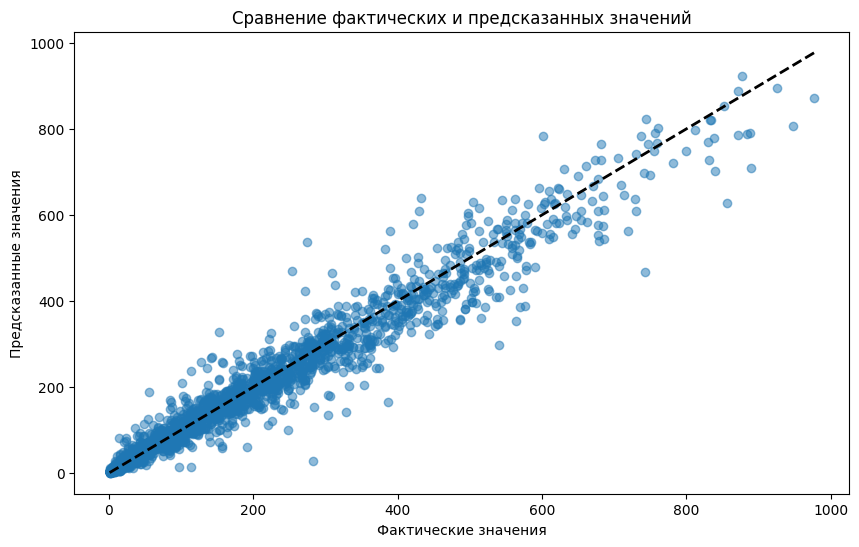

In [ ]:
# Сравнение предсказанных и фактических значений

plt.figure(figsize=(10,6))
plt.scatter(y_test_true, y_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'k--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')

plt.show()

 <font color='#0066CC'>  Оценка важности переменных с помощью SHAP и permitation feature importance

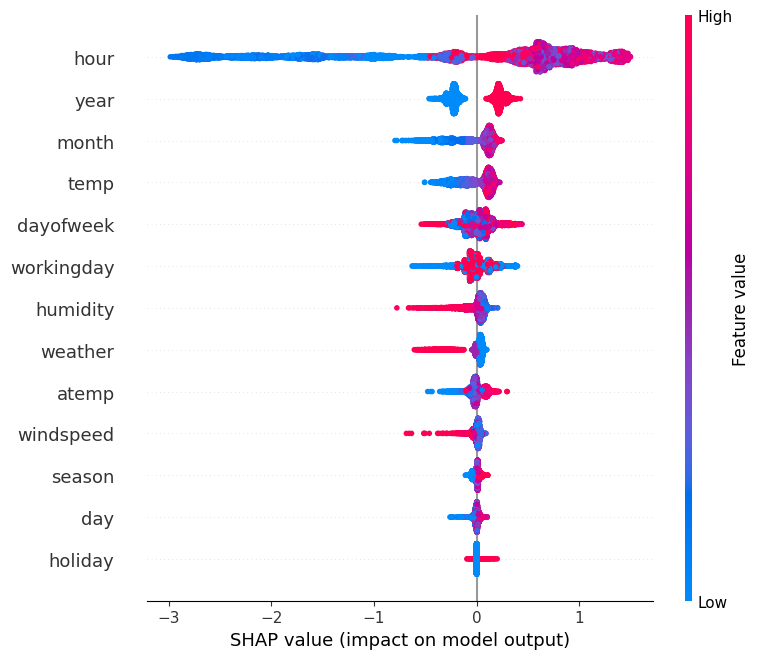

In [ ]:
# SHAP
explainer = shap.TreeExplainer(best_model_GBR)
shap_value = explainer.shap_values(x_train_scaled)

# График SHAP
shap.summary_plot(shap_value, x_train_scaled)

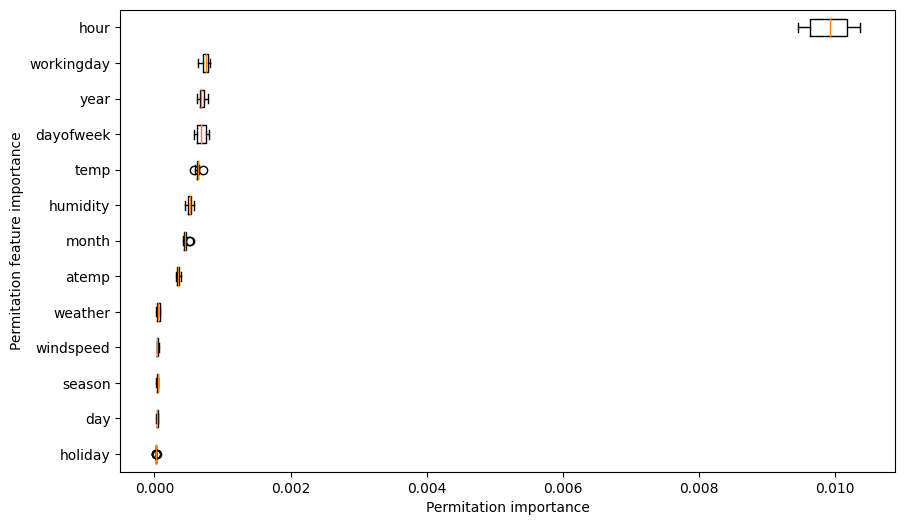

In [ ]:
# permitation feature importance
result = permutation_importance(best_model_GBR, x_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# График с boxplot
sorted_index = result.importances_mean.argsort()
plt.figure(figsize=(10,6))
plt.boxplot(result.importances[sorted_index].T, vert=False, labels=x_train.columns[sorted_index])
plt.xlabel('Permitation importance')
plt.ylabel('Permitation feature importance')

plt.show()

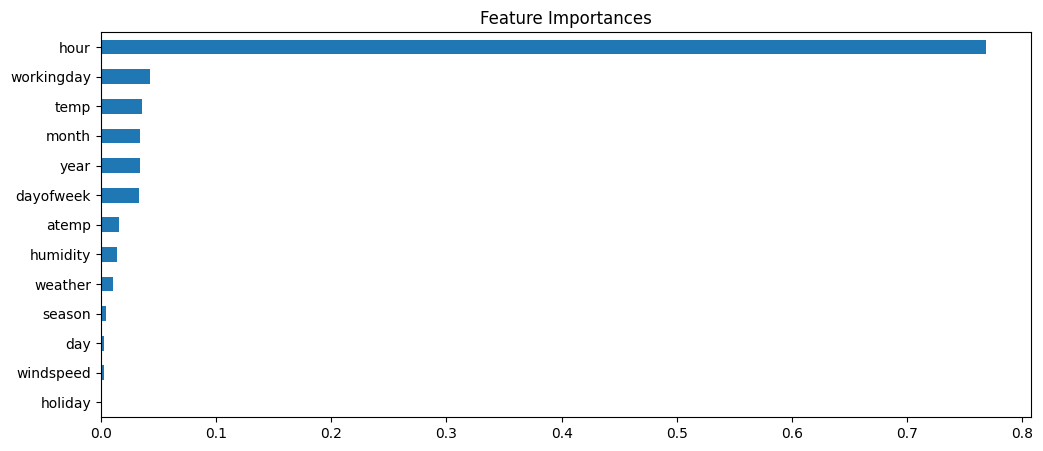

In [ ]:
# График с barh
feature_importances = pd.Series(best_model_GBR.feature_importances_, index=x_train.columns)

feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 5))
plt.title('Feature Importances')
feature_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

# <font color='#0000FF' size='6'> **Применение алгоритма к тестовой выборке df_test и сабмит решения на kaggle**

In [ ]:
df_test_enc = df_test.copy()

y_pred_test_full = best_model_GBR.predict(x_test_scaled)

# Создание файла для сабмита на Kaggle
df_test['count'] = y_pred_test_full[0]
submission = df_test[['datetime', 'count']]
submission.to_csv('/content/submissions.csv', index=False)

print(submission.head())

# Загрузка результатов на Kaggle
from google.colab import drive
drive.mount('/content/drive')

!pip install kaggle -q
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions submit -c bike-sharing-demand -f /content/submissions.csv -m "GBR"

              datetime     count
0  2011-01-20 00:00:00  4.786417
1  2011-01-20 01:00:00  4.786417
2  2011-01-20 02:00:00  4.786417
3  2011-01-20 03:00:00  4.786417
4  2011-01-20 04:00:00  4.786417
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 241k/241k [00:00<00:00, 1.31MB/s]
Successfully submitted to Bike Sharing Demand